# Recursive Feature Elimination (RFE)

## Read data

In [2]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_qc_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


## Extract data

In [7]:
X = dataDf.drop(['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'onetwenty_day_mortality'], axis = 1)
y_seven_day = dataDf['seven_day_mortality']
y_fourteen_day = dataDf['fourteen_day_mortality']
y_twentyone_day = dataDf['twentyone_day_mortality']
y_twentyeight_day = dataDf['twentyeight_day_mortality']
y_sixty_day = dataDf['sixty_day_mortality']
y_ninety_day = dataDf['ninety_day_mortality']
y_onetwenty_day = dataDf['onetwenty_day_mortality']

## Seven day mortality prediction

### RFE

In [14]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
# fit RFE
rfe.fit(X, y_seven_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

In [15]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,145
1,Ambulatory Surgical Center,False,144
2,Emergency Room - Hospital,False,143
3,Emergency Room and Inpatient Visit,False,142
4,Inpatient Visit,False,140
...,...,...,...
154,sodium_last,False,122
155,bicarbonate_last,True,1
156,hemoglobin_last,False,34
157,creatinine_last,False,59


In [16]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
30,resp_rate_max,True,1
47,sysbp_min,True,1
48,diabp_min,True,1
50,sysbp_ni_min,True,1
56,temp_avg,True,1
64,meanbp_avg,True,1
71,temp_sd,True,1
113,gcs_motor_last,True,1
137,potassium_sd,True,1


### RFECV

In [25]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
)

rfecv.fit(X, y_seven_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [26]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 153


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


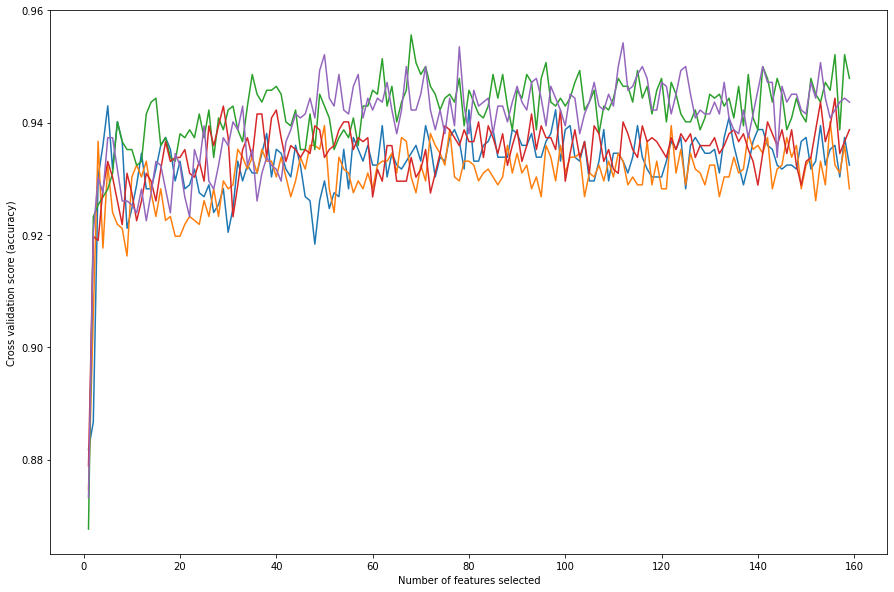

In [27]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


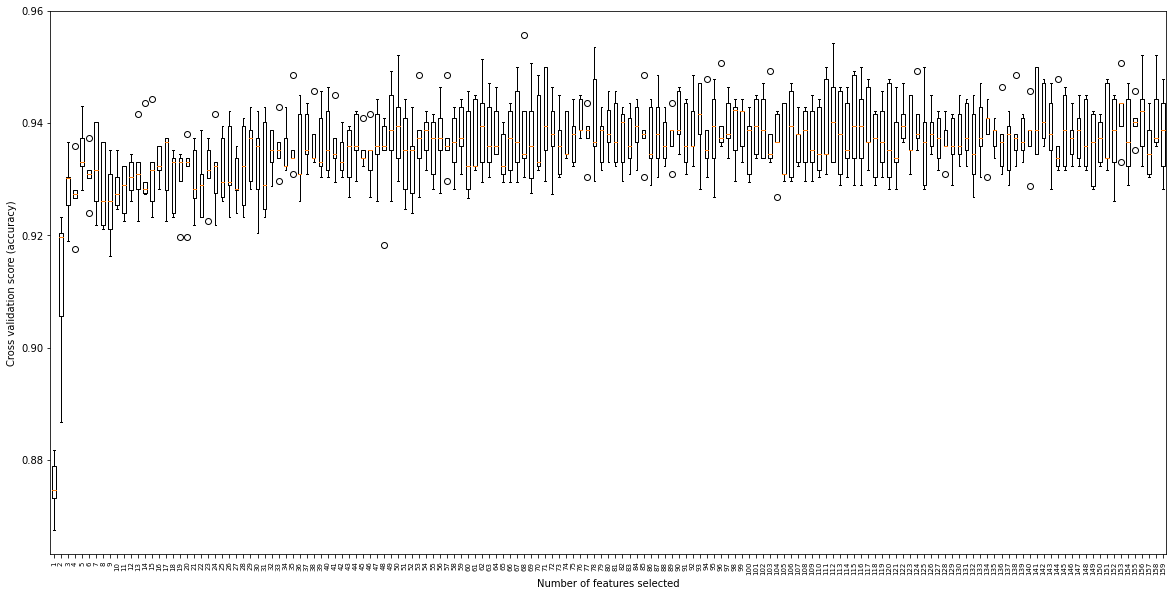

In [46]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

## Fourteen day mortality prediction

### RFE

In [48]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
# fit RFE
rfe.fit(X, y_fourteen_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

In [49]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,145
1,Ambulatory Surgical Center,False,144
2,Emergency Room - Hospital,False,143
3,Emergency Room and Inpatient Visit,False,140
4,Inpatient Visit,False,139
...,...,...,...
154,sodium_last,False,74
155,bicarbonate_last,True,1
156,hemoglobin_last,False,36
157,creatinine_last,False,5


In [50]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
26,temp_max,True,1
57,heartrate_avg,True,1
64,meanbp_avg,True,1
65,sysbp_ni_avg,True,1
76,oxygen_sd,True,1
96,diabp_ni_first,True,1
110,sysbp_ni_last,True,1
113,gcs_motor_last,True,1
115,gcs_eye_last,True,1


### RFECV

In [51]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
)

rfecv.fit(X, y_fourteen_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [52]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 118


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


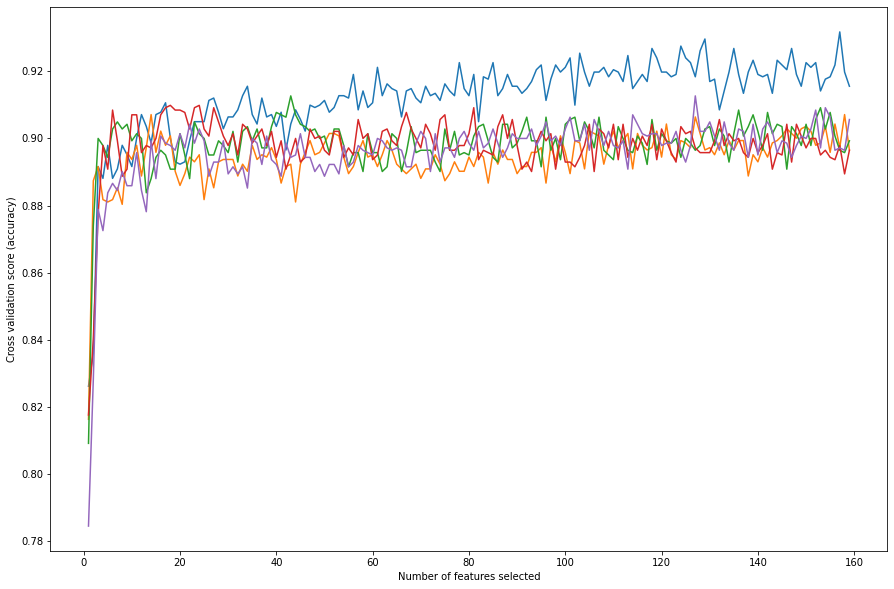

In [53]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


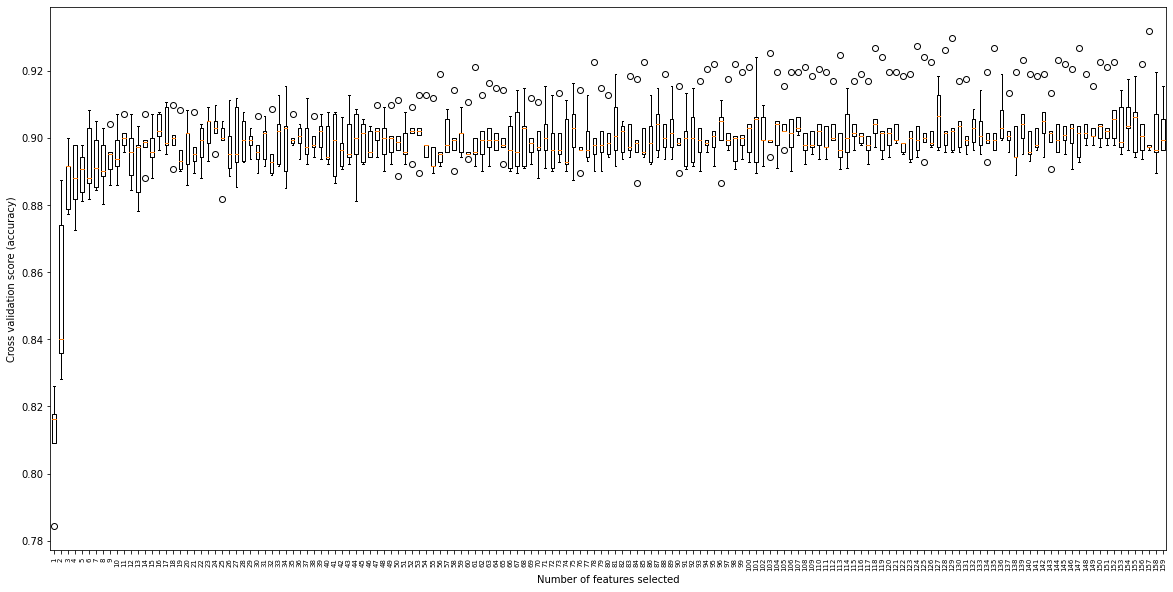

In [54]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

## Twentyone day mortality prediction

### RFE

In [55]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
# fit RFE
rfe.fit(X, y_twentyone_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

In [56]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,145
1,Ambulatory Surgical Center,False,144
2,Emergency Room - Hospital,False,141
3,Emergency Room and Inpatient Visit,False,136
4,Inpatient Visit,False,126
...,...,...,...
154,sodium_last,False,107
155,bicarbonate_last,True,1
156,hemoglobin_last,False,95
157,creatinine_last,True,1


In [57]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
26,temp_max,True,1
35,sysbp_ni_max,True,1
48,diabp_min,True,1
56,temp_avg,True,1
61,oxygen_avg,True,1
76,oxygen_sd,True,1
110,sysbp_ni_last,True,1
113,gcs_motor_last,True,1
131,chloride_avg,True,1


### RFECV

In [58]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
)

rfecv.fit(X, y_twentyone_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [59]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 53


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


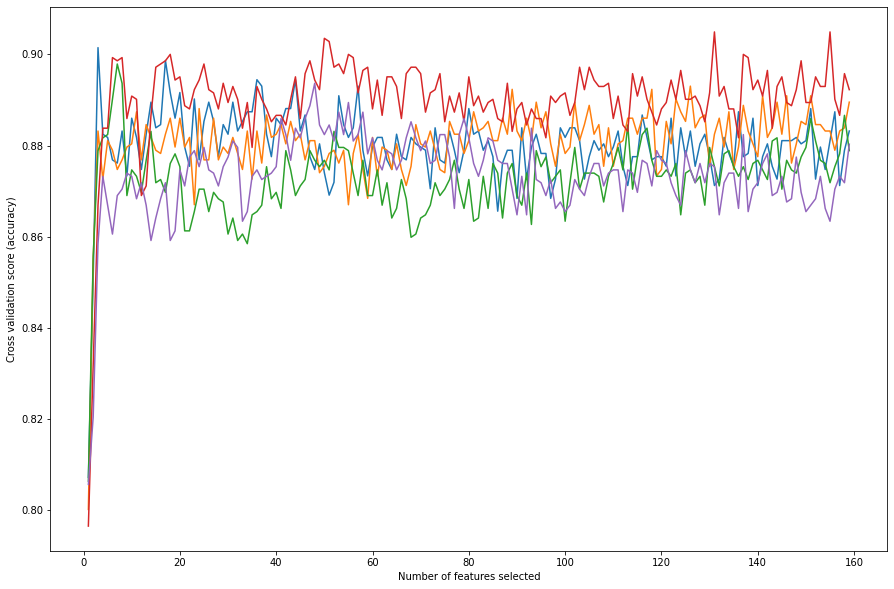

In [60]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


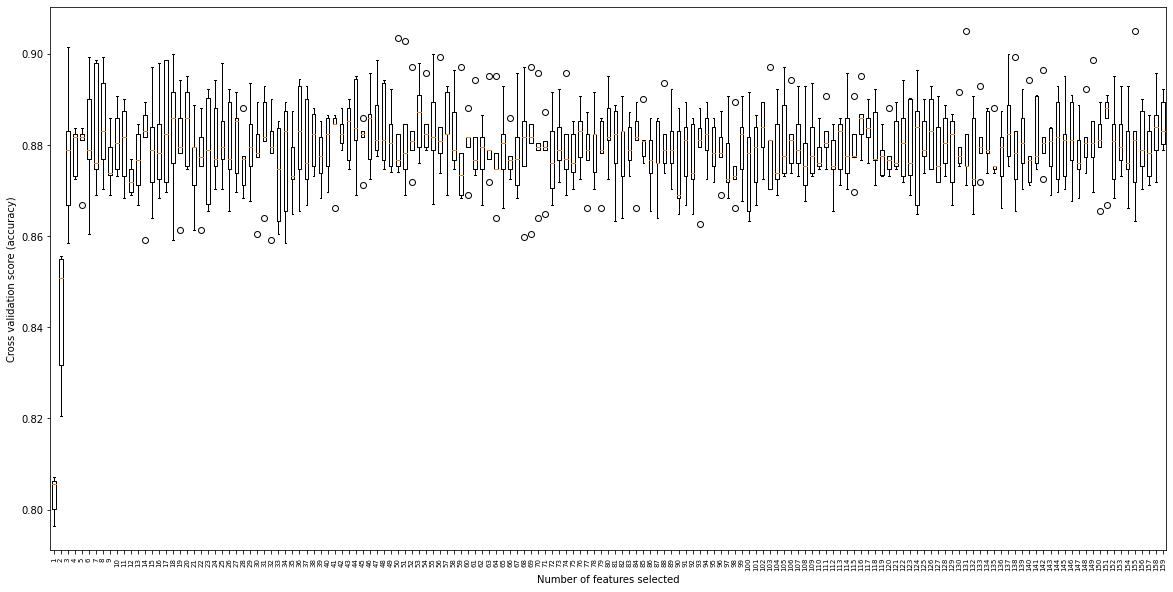

In [61]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

## Twentyeight day mortality prediction

### RFE

In [62]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
# fit RFE
rfe.fit(X, y_twentyeight_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

In [63]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,145
1,Ambulatory Surgical Center,False,143
2,Emergency Room - Hospital,False,141
3,Emergency Room and Inpatient Visit,False,140
4,Inpatient Visit,False,139
...,...,...,...
154,sodium_last,False,62
155,bicarbonate_last,True,1
156,hemoglobin_last,False,83
157,creatinine_last,False,81


In [64]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
27,heartrate_max,True,1
61,oxygen_avg,True,1
65,sysbp_ni_avg,True,1
70,gcs_eye_avg,True,1
92,sysbp_first,True,1
102,heartrate_last,True,1
109,meanbp_last,True,1
113,gcs_motor_last,True,1
128,hemoglobin_min,True,1


### RFECV

In [65]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
)

rfecv.fit(X, y_twentyeight_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [66]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 138


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


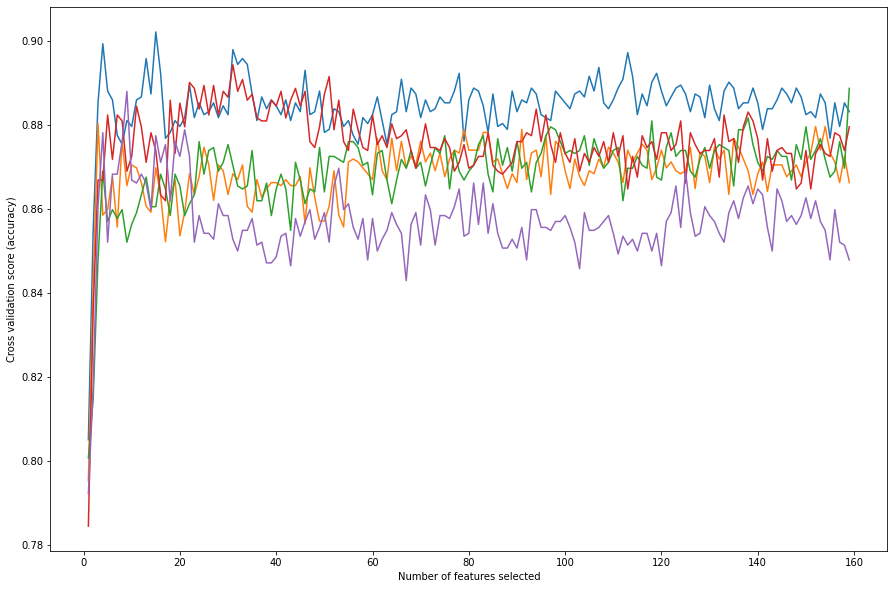

In [67]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


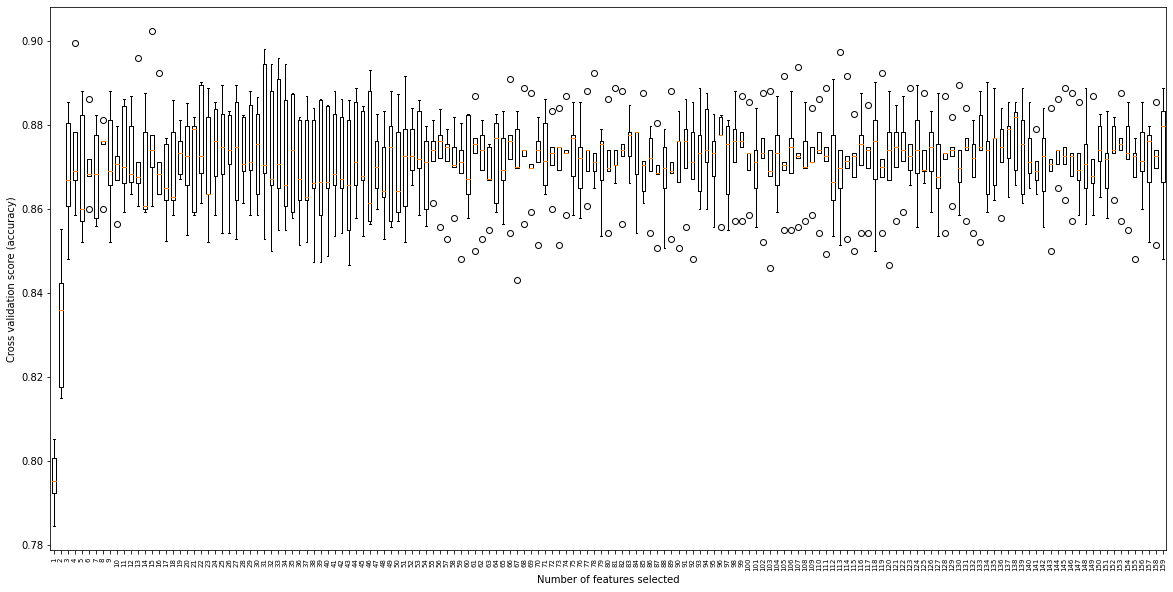

In [68]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

## Sixty day mortality prediction

### RFE

In [69]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
# fit RFE
rfe.fit(X, y_sixty_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

In [70]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,145
1,Ambulatory Surgical Center,False,144
2,Emergency Room - Hospital,False,142
3,Emergency Room and Inpatient Visit,False,141
4,Inpatient Visit,False,134
...,...,...,...
154,sodium_last,False,36
155,bicarbonate_last,True,1
156,hemoglobin_last,False,16
157,creatinine_last,False,128


In [71]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
37,meanbp_ni_max,True,1
42,heartrate_min,True,1
48,diabp_min,True,1
56,temp_avg,True,1
65,sysbp_ni_avg,True,1
66,diabp_ni_avg,True,1
72,heartrate_sd,True,1
113,gcs_motor_last,True,1
118,glucose_max,True,1


### RFECV

In [72]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
)

rfecv.fit(X, y_sixty_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [73]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 139


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


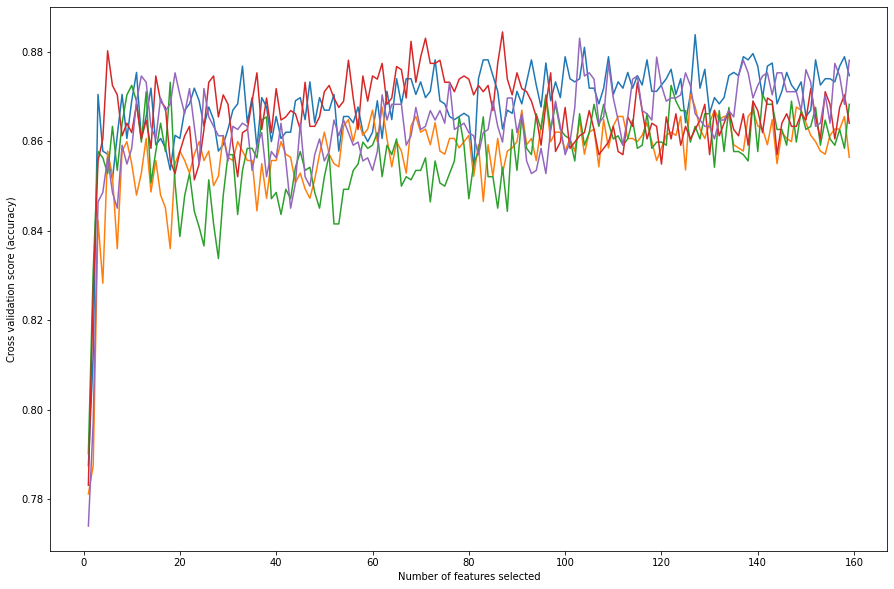

In [74]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


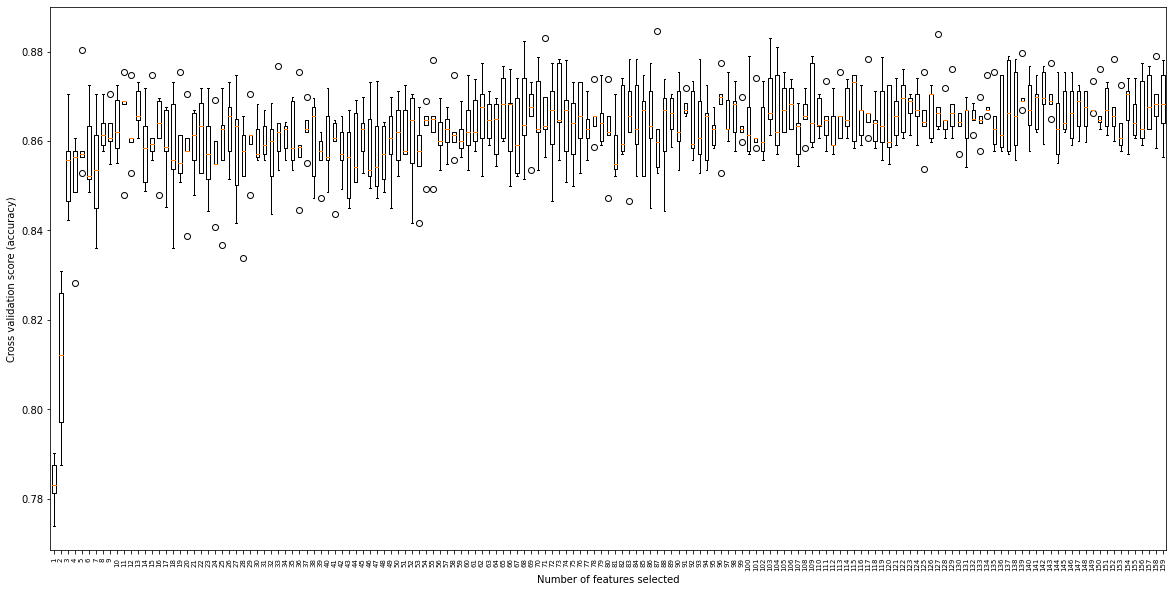

In [75]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

## Ninety day mortality prediction

### RFE

In [76]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
# fit RFE
rfe.fit(X, y_ninety_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

In [77]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,145
1,Ambulatory Surgical Center,False,144
2,Emergency Room - Hospital,False,141
3,Emergency Room and Inpatient Visit,False,140
4,Inpatient Visit,False,138
...,...,...,...
154,sodium_last,False,33
155,bicarbonate_last,True,1
156,hemoglobin_last,False,95
157,creatinine_last,False,122


In [78]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
42,heartrate_min,True,1
56,temp_avg,True,1
63,diabp_avg,True,1
65,sysbp_ni_avg,True,1
76,oxygen_sd,True,1
113,gcs_motor_last,True,1
118,glucose_max,True,1
125,glucose_min,True,1
126,sodium_min,True,1


### RFECV

In [79]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
)

rfecv.fit(X, y_ninety_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [80]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 134


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


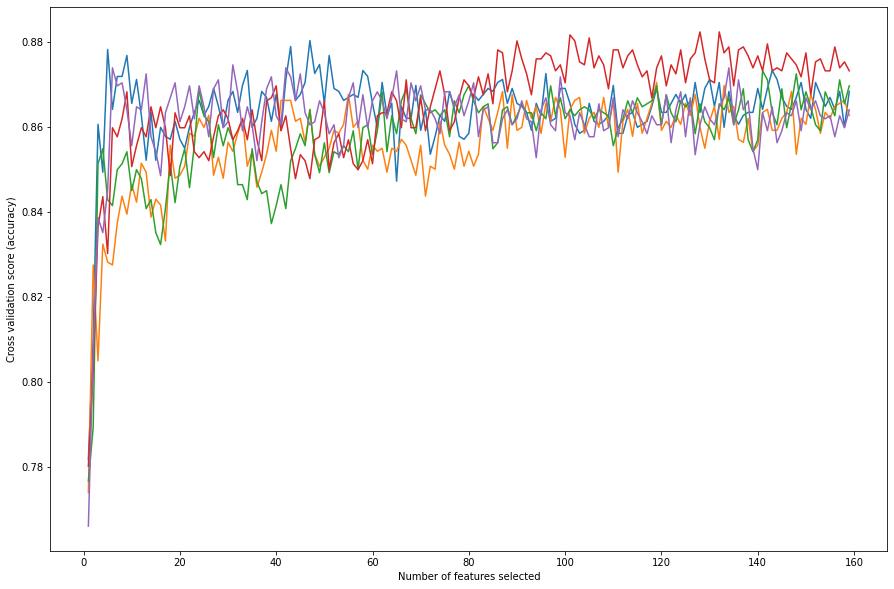

In [81]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


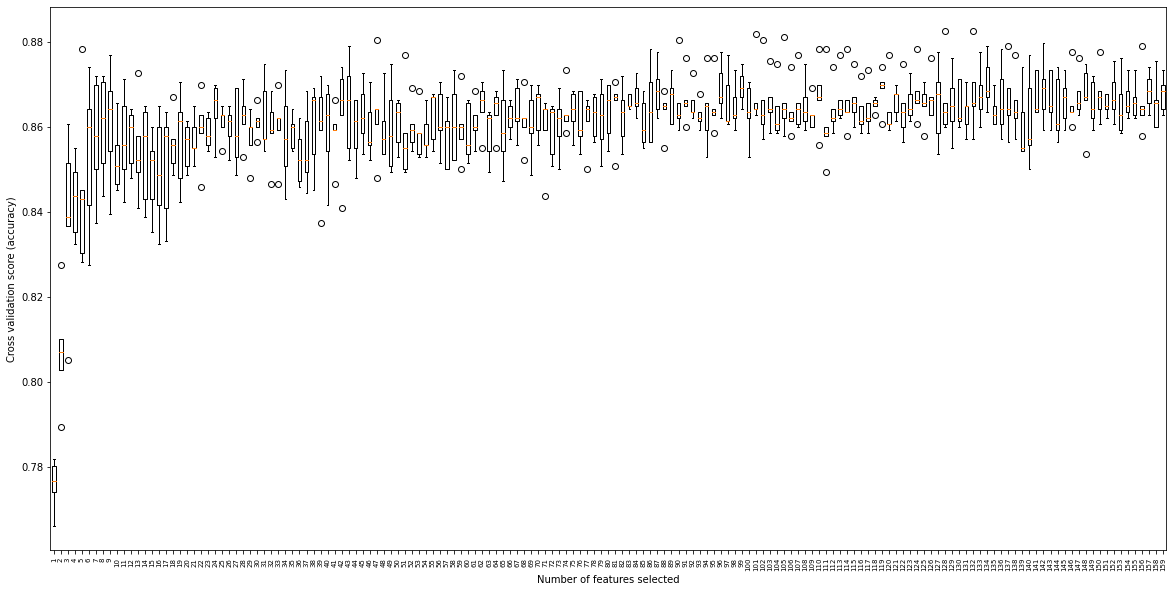

In [82]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()

## Onetwenty day mortality prediction

### RFE

In [83]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
# fit RFE
rfe.fit(X, y_onetwenty_day)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

In [84]:
# summarize all features
data = []
columns = X.columns
for i in range(X.shape[1]):
    data.append([columns[i], rfe.support_[i], rfe.ranking_[i]])
	# print('Column: %s, Selected %s, Rank: %.3f' % (columns[i], rfe.support_[i], rfe.ranking_[i]))
feDf = pd.DataFrame(data, columns=['Column', 'Selected', 'Rank'])
feDf

,Column,Selected,Rank
0,Ambulatory Clinic / Center,False,144
1,Ambulatory Surgical Center,False,143
2,Emergency Room - Hospital,False,142
3,Emergency Room and Inpatient Visit,False,141
4,Inpatient Visit,False,140
...,...,...,...
154,sodium_last,False,25
155,bicarbonate_last,True,1
156,hemoglobin_last,False,92
157,creatinine_last,False,108


In [85]:
feDf[feDf.Selected]

,Column,Selected,Rank
25,visit_duration_hrs,True,1
48,diabp_min,True,1
56,temp_avg,True,1
65,sysbp_ni_avg,True,1
72,heartrate_sd,True,1
76,oxygen_sd,True,1
87,heartrate_first,True,1
110,sysbp_ni_last,True,1
113,gcs_motor_last,True,1
125,glucose_min,True,1


### RFECV

In [86]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    cv=StratifiedKFold(5),
    scoring = "accuracy",
    min_features_to_select = min_features_to_select,
)

rfecv.fit(X, y_onetwenty_day)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [87]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 96


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


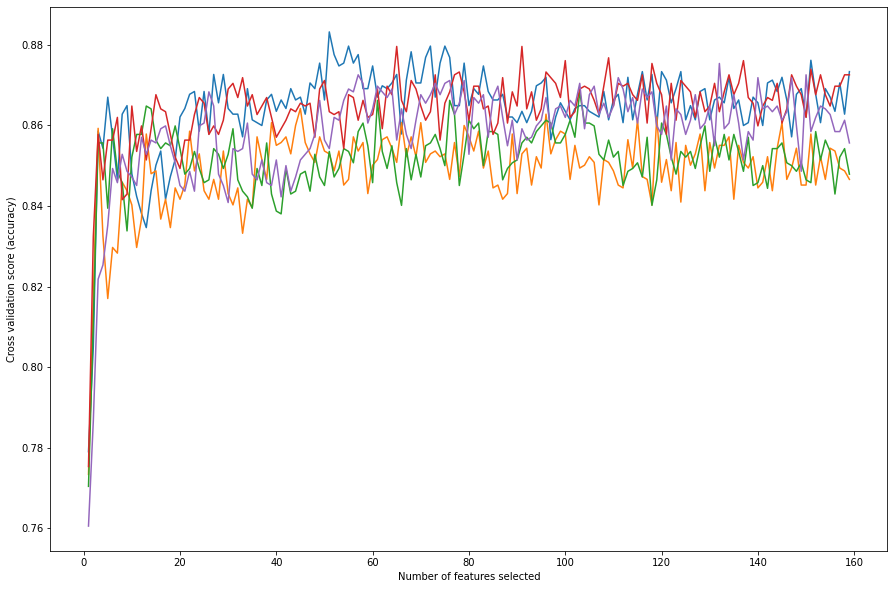

In [88]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


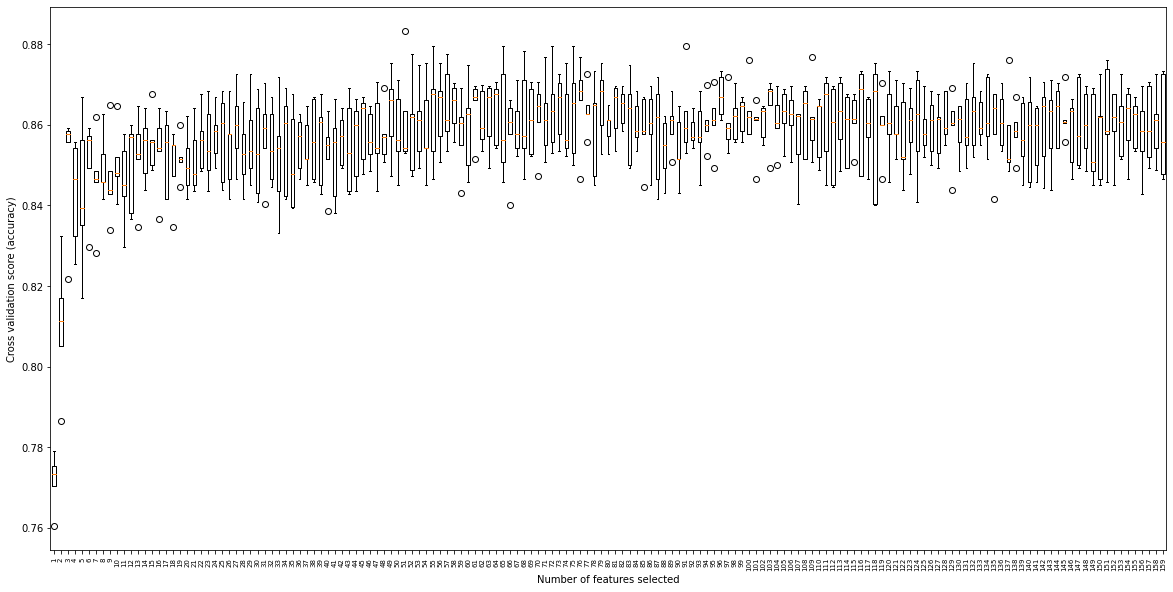

In [89]:
from matplotlib import pyplot as plt

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.boxplot(
    # range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.transpose(),
)
plt.show()